In [1]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

seed = 232
np.random.seed(seed)
tf.set_random_seed(seed)

Using TensorFlow backend.


Set: train, chest images: 1349, oct images: 1351
Set: test, chest images: 234, oct images: 235


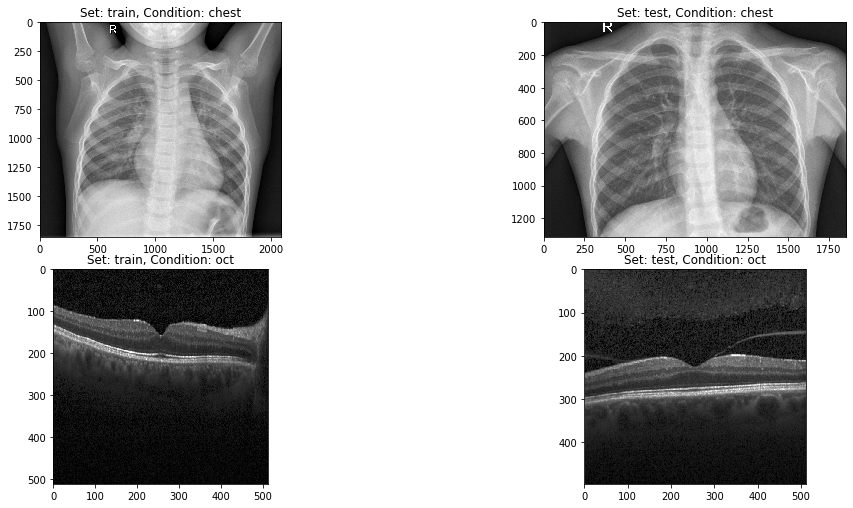

In [4]:
input_path = 'C:/Users/rituj/Desktop/project/first_data/'
class pre:
    

    fig, ax = plt.subplots(2, 2, figsize=(15, 7))
    ax = ax.ravel()
    plt.tight_layout()

    
    for i, _set in enumerate(['train', 'test']):
        set_path = input_path+_set
        ax[i].imshow(plt.imread(set_path+'/chest/'+os.listdir(set_path+'/chest')[0]), cmap='gray')
        ax[i].set_title('Set: {}, Condition: chest'.format(_set))
        ax[i+2].imshow(plt.imread(set_path+'/oct/'+os.listdir(set_path+'/oct')[0]), cmap='gray')
        ax[i+2].set_title('Set: {}, Condition: oct'.format(_set))
        
    for _set in ['train', 'test']:
        n_chest = len(os.listdir(input_path + _set + '/chest'))
        n_oct = len(os.listdir(input_path + _set + '/oct'))
        print('Set: {}, chest images: {}, oct images: {}'.format(_set, n_chest, n_oct))
    @staticmethod
    def process_data(img_dims, batch_size):
        # Data generation objects
        train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
        test_val_datagen = ImageDataGenerator(rescale=1./255)

        # This is fed to the network in the specified batch sizes and image dimensions
        train_gen = train_datagen.flow_from_directory(
        directory=input_path+'train', 
        target_size=(img_dims, img_dims), 
        batch_size=batch_size, 
        class_mode='binary', 
        shuffle=True)

        test_gen = test_val_datagen.flow_from_directory(
        directory=input_path+'test', 
        target_size=(img_dims, img_dims), 
        batch_size=batch_size, 
        class_mode='binary', 
        shuffle=True)

        # I will be making predictions off of the test set in one batch size
        # This is useful to be able to get the confusion matrix
        test_data = []
        test_labels = []

        for cond in ['/chest/', '/oct/']:
            for img in (os.listdir(input_path + 'test' + cond)):
                img = plt.imread(input_path+'test'+cond+img)
                img = cv2.resize(img, (img_dims, img_dims))
                img = np.dstack([img, img, img])
                img = img.astype('float32') / 255
                if cond=='/chest/':
                    label = 0
                elif cond=='/oct/':
                    label = 1
                test_data.append(img)
                test_labels.append(label)

        test_data = np.array(test_data)
        test_labels = np.array(test_labels)

        return train_gen, test_gen, test_data, test_labels

In [7]:
img_dims = 150
epochs = 10
batch_size = 32
p=pre()
train_gen, test_gen, test_data, test_labels = p.process_data(img_dims, batch_size)
inputs = Input(shape=(img_dims, img_dims, 3))

Found 2700 images belonging to 2 classes.
Found 469 images belonging to 2 classes.



In [6]:
class first():
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Dropout(rate=0.2)(x)

    x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Dropout(rate=0.2)(x)

    x = Flatten()(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dropout(rate=0.7)(x)
    x = Dense(units=128, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=64, activation='relu')(x)
    x = Dropout(rate=0.3)(x)

    output = Dense(units=1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    
    @staticmethod    
    def callback():
        # Callbacks
        checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
        lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
        early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')
        callbacks=[checkpoint, lr_reduce]
        return callbacks

NameError: name 'inputs' is not defined

In [32]:
# Fitting the model

m=first()
c=m.callback()
hist = m.model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=c)

Epoch 1/10
84/84 [==============================] - 131s 2s/step - loss: 0.1352 - acc: 0.9580 - val_loss: 0.7977 - val_acc: 0.5670
Epoch 2/10
84/84 [==============================] - 116s 1s/step - loss: 0.0061 - acc: 0.9989 - val_loss: 1.0954e-07 - val_acc: 1.0000
Epoch 3/10
84/84 [==============================] - 125s 1s/step - loss: 0.0276 - acc: 0.9981 - val_loss: 1.0980e-07 - val_acc: 1.0000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/10
84/84 [==============================] - 116s 1s/step - loss: 0.0250 - acc: 0.9978 - val_loss: 1.0954e-07 - val_acc: 1.0000
Epoch 5/10
84/84 [==============================] - 115s 1s/step - loss: 0.0203 - acc: 0.9970 - val_loss: 1.1002e-07 - val_acc: 1.0000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 6/10
84/84 [==============================] - 126s 1s/step - loss: 0.0021 - acc: 0.9996 - val_loss: 1.0936e-07 - val_acc: 1.0000
Epoch 7/10
84/84 [==============

In [37]:
class op:
    @staticmethod
    def plo():
        fig, ax = plt.subplots(1, 2, figsize=(10, 3))
        ax = ax.ravel()

        for i, met in enumerate(['acc', 'loss']):
            ax[i].plot(hist.history[met])
            ax[i].plot(hist.history['val_' + met])
            ax[i].set_title('Model {}'.format(met))
            ax[i].set_xlabel('epochs')
            ax[i].set_ylabel(met)
            ax[i].legend(['train', 'val'])
    @staticmethod
    def op1():        
        from sklearn.metrics import accuracy_score, confusion_matrix

        preds = m.model.predict(test_data)

        acc = accuracy_score(test_labels, np.round(preds))*100
        cm = confusion_matrix(test_labels, np.round(preds))
        tn, fp, fn, tp = cm.ravel()

        print('CONFUSION MATRIX ------------------')
        print(cm)

        print('\nTEST METRICS ----------------------')
        precision = tp/(tp+fp)*100
        recall = tp/(tp+fn)*100
        print('Accuracy: {}%'.format(acc))
        print('Precision: {}%'.format(precision))
        print('Recall: {}%'.format(recall))
        print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

        print('\nTRAIN METRIC ----------------------')
        print('Train acc: {}'.format(np.round((hist.history['acc'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[234   0]
 [  0 235]]

TEST METRICS ----------------------
Accuracy: 100.0%
Precision: 100.0%
Recall: 100.0%
F1-score: 100.0

TRAIN METRIC ----------------------
Train acc: 99.93


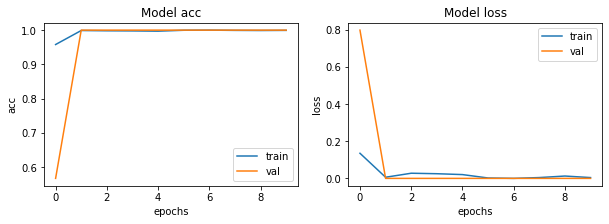

In [38]:
r=op()
r.plo()
r.op1()

In [8]:
m.model.save('f_c.h5')

NameError: name 'm' is not defined